# **Deep Learning – [Image Captioning]**


---

***Problem Statement: 'Image Captioning is the process of generating textual description of an image. It uses both Natural Language Processing and Computer Vision to generate the captions'***


---


# ***Import Required Python, Keras, and Tensorflow Libraries/Dataset***

In [ ]:
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import layers
import random
import string
import os
from PIL import Image
from pickle import dump, load
import numpy as np
import pandas as pd
print(tf.__version__)
from sklearn.model_selection import train_test_split
from tensorflow.python.summary.writer.writer import FileWriter # for viewing Tensor graph
%load_ext tensorboard

2.8.0
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers.merge import add
from keras.models import Model, load_model
from keras.layers import Input, Dense, LSTM, Embedding, Dropout
# small library for seeing the progress of loops.
from tqdm import tqdm_notebook as tqdm
tqdm().pandas()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


0it [00:00, ?it/s]

***Mounting google drive to read and load the image and caption dataset***

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Input Path 
caption_path = '/content/drive/MyDrive/Colab Notebooks/set_0.pkl'
image_path = '/content/drive/MyDrive/Colab Notebooks/image_captioning_dataset.zip'
image_path_ = '/content/drive/MyDrive/Colab Notebooks/Flicker8k_Dataset'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# ***Data Processing***

***load_caption(): Function that, load and reads caption pickle file given, Function will return a dictionary of photo identifiers to descriptions. Each photo identifier maps to a list of one or more textual descriptions.s***


In [ ]:
# get all imgs with their captions
def load_caption(filename):
    captions = pd.read_pickle(filename)
    descriptions ={}
    for caption in captions[:-1]:
        img, caption = caption.split('\t')
        if img[:-2] not in descriptions:
            descriptions[img[:-2]] = [ caption ]
        else:
            descriptions[img[:-2]].append(caption)
    return descriptions

In [ ]:
image_caption = load_caption(caption_path)

In [ ]:
# Output of caption dictionary created
print(image_caption['2463067409_78188c584c.jpg'])
print("\n")
print(image_caption['2463067409_78188c584c.jpg'])
print("\n")
print("Length of descriptions =" ,len(image_caption))

['A dog run through the grass towards the camera .', 'A large gray dog carry a ball in its mouth run across the grass towards the camera .', 'A black dog , run on grass .']


Length of descriptions = 8037


**Display of test image and description**



['girl go into wooden building', 'little girl climb into wooden playhouse', 'child in pink dress be climb up set of stair in an entry way']


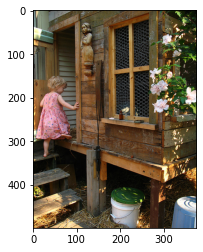

In [ ]:
img = Image.open('/content/drive/MyDrive/Colab Notebooks/Flicker8k_Dataset/1000268201_693b08cb0e.jpg')
print("\n")
print(image_caption['1000268201_693b08cb0e.jpg'])

plt.imshow(img)



['child play on rope net', 'little girl in pink climb rope bridge at park', 'small child climb on red rope on playground', 'small child grip onto red rope at playground', 'little girl climb on red rope']


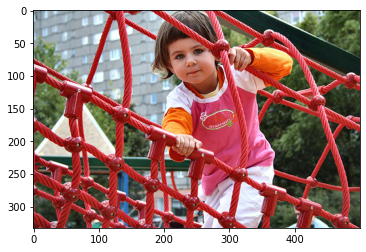

In [ ]:
img = Image.open('/content/drive/MyDrive/Colab Notebooks/Flicker8k_Dataset/1007320043_627395c3d8.jpg')
print("\n")
print(image_caption['1007320043_627395c3d8.jpg'])

plt.imshow(img)

***cleaning_text( descriptions) – This function takes all descriptions and performs data cleaning. This is an important step when we work with textual data, according to our goal, we decide what type of cleaning we want to perform on the text. In our case, we will be removing punctuations, converting all text to lowercase and removing words that contain numbers***
`*So, a caption like “A dog run through the grass towards the camera .” will be transformed into “a dog run through the grass towards the camera”*`

---


***text_vocabulary( descriptions ) – This is a simple function that will separate all the unique words and create the vocabulary from all the descriptions***

---

***save_descriptions( descriptions, filename ) – This function will create a list of all the descriptions that have been preprocessed and store them into a file***.

In [ ]:
#Data cleaning- lower casing, removing puntuations and words containing numbers
def cleaning_text(captions):
    table = str.maketrans('','',string.punctuation)
    for img,caps in captions.items():
        for i,img_caption in enumerate(caps):

            img_caption.replace("-"," ")
            desc = img_caption.split()

            #converts to lowercase
            desc = [word.lower() for word in desc]
            #remove punctuation from each token
            desc = [word.translate(table) for word in desc]
            #remove hanging 's and a 
            desc = [word for word in desc if(len(word)>1)]
            #remove tokens with numbers in them
            desc = [word for word in desc if(word.isalpha())]
            #convert back to string

            img_caption = ' '.join(desc)
            captions[img][i]= img_caption
    return captions

def text_vocabulary(descriptions):
    # build vocabulary of all unique words
    vocab = set()

    for key in descriptions.keys():
        [vocab.update(d.split()) for d in descriptions[key]]

    return vocab

#All descriptions in one file 
def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + '\t' + desc )
    data = "\n".join(lines)
    file = open(filename,"w")
    file.write(data)
    file.close()


#cleaning the descriptions
clean_descriptions = cleaning_text(image_caption)

#building vocabulary 
vocabulary = text_vocabulary(clean_descriptions)
print("Length of vocabulary = ", len(vocabulary))

#saving each description to file 
save_descriptions(clean_descriptions, "/content/drive/MyDrive/Colab Notebooks/descriptions.txt")

Length of vocabulary =  5490


### ***Extracting the feature vector from all images*** 

In [ ]:
# ! pip install wget
# # import wget
# # url='https://drive.google.com/file/d/1-mPKMpphaKqtT26ZzbR5hCHGedkNyAf1/view?usp=sharing'
# # wget.download(url)

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=bfa75401332fbae776014716bbaf3ac1525a838fe882260b23cbf8af43da2dfa
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [ ]:
#import zipfile module
from zipfile import ZipFile
with ZipFile(image_path, 'r') as f:
  #extract in current directory
  f.extractall()

# importing shutil module 
import shutil
# Path of the file
# Target directory
extract_dir = "/content/drive/MyDrive/Colab Notebooks/"
# Unzip the file 
shutil.unpack_archive(image_path, extract_dir)

### **Loading dataset for Training and testing the model**



 Creating split of 6000 and 2000 image names that we will use for training and testing purpouse respectiviley.

In [ ]:
def read_doc(filename):
    # Opening the file as read only
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

def load_photos(filename):
    file = read_doc(filename)
    photos = file.split("\n")[:-1]
    return photos


def load_clean_descriptions(filename, photos): 
    #loading clean_descriptions
    file = read_doc(filename)
    descriptions = {}
    for line in file.split("\n"):

        words = line.split()
        if len(words)<1 :
            continue

        image, image_caption = words[0], words[1:]

        if image in photos:
            if image not in descriptions:
                descriptions[image] = []
            desc = '<start> ' + " ".join(image_caption) + ' <end>'
            descriptions[image].append(desc)

    return descriptions


def load_features(photos):
    #loading all features
    all_features = load(open("features.p","rb"))
    #selecting only needed features
    features = {k:all_features[k] for k in photos}
    return features


filename = '/content/drive/MyDrive/Colab Notebooks/Flickr_8k.trainImages.txt'

#train = loading_data(filename)
train_imgs = load_photos(filename)
train_descriptions = load_clean_descriptions("/content/drive/MyDrive/Colab Notebooks/descriptions.txt", train_imgs)
train_features = load_features(train_imgs)

***The function extract_features() will extract features for all images and we will map image names with their respective feature array. Then we will dump the features dictionary into a “features.p” pickle file.***

# ***Model Building***

**Use Pretrained VGG-16 model trained on ImageNet dataset (available publicly on google) for image feature extraction.**

In [ ]:
def extract_features(directory):
        model = VGG16( include_top=False, pooling='avg' )
        features = {}
        for img in tqdm(os.listdir(directory)):
            filename = directory + "/" + img
            image = Image.open(filename)
            image = image.resize((299,299))
            image = np.expand_dims(image, axis=0)
            #image = preprocess_input(image)
            image = image/127.5
            image = image - 1.0

            feature = model.predict(image)
            features[img] = feature
        return features

#2048 feature vector
features = extract_features(image_path_)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


  0%|          | 0/8091 [00:00<?, ?it/s]

NameError: ignored

In [ ]:
from pickle import dump, load

dump(features, open("/content/drive/MyDrive/Colab Notebooks/features.p","wb"))
features = load(open("/content/drive/MyDrive/Colab Notebooks/features.p","rb"))

### ***Tokenizing the vocabulary***



In [ ]:
#converting dictionary to clean list of descriptions
def dict_to_list(descriptions):
    all_desc = []
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

#creating tokenizer class 
#this will vectorise text corpus
#each integer will represent token in dictionary

from keras.preprocessing.text import Tokenizer

def create_tokenizer(descriptions):
    desc_list = dict_to_list(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(desc_list)
    return tokenizer

# give each word an index, and store that into tokenizer.p pickle file
tokenizer = create_tokenizer(train_descriptions)
dump(tokenizer, open('/content/drive/MyDrive/Colab Notebooks/tokenizer.p', 'wb'))
vocab_size = len(tokenizer.word_index) + 1
vocab_size

4709

In [ ]:
#calculate maximum length of descriptions
def max_length(descriptions):
    desc_list = dict_to_list(descriptions)
    return max(len(d.split()) for d in desc_list)
    
max_length = max_length(image_caption)
max_length

29

In [ ]:
#create input-output sequence pairs from the image description.

#data generator, used by model.fit_generator()
def data_generator(descriptions, features, tokenizer, max_length):
    while 1:
        for key, description_list in descriptions.items():
            #retrieve photo features
            feature = features[key][0]
            input_image, input_sequence, output_word = create_sequences(tokenizer, max_length, description_list, feature)
            yield [[input_image, input_sequence], output_word]

def create_sequences(tokenizer, max_length, desc_list, feature):
    X1, X2, y = list(), list(), list()
    # walk through each description for the image
    for desc in desc_list:
        # encode the sequence
        seq = tokenizer.texts_to_sequences([desc])[0]
        # split one sequence into multiple X,y pairs
        for i in range(1, len(seq)):
            # split into input and output pair
            in_seq, out_seq = seq[:i], seq[i]
            # pad input sequence
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            # encode output sequence
            out_seq = tf.keras.utils.to_categorical([out_seq], num_classes=vocab_size)[0]
            # store
            X1.append(feature)
            X2.append(in_seq)
            y.append(out_seq)
    return np.array(X1), np.array(X2), np.array(y)

[a,b],c = next(data_generator(train_descriptions, features, tokenizer, max_length))
a.shape, b.shape, c.shape


((30, 2048), (30, 29), (30, 4709))

## ***Defining the CNN-RNN model***




```
1. Create 3 layered RNN layer model and other relevant layers for image caption generation
2. Add L2 regularization to all the RNN layers
3. Add one layer of dropout at the appropriate position
4. Choose the appropriate activation function for all the layers. 
5. Print the model summary.
```






The Dropout layer randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting. Inputs not set to 0 are scaled up by 1/(1 - rate) such that the sum over all inputs is unchanged.

In [ ]:
## Defining the CNN-RNN model

from keras.utils.vis_utils import plot_model

# define the captioning model
def define_model(vocab_size, max_length):

    # features from the CNN model squeezed from 2048 to 256 nodes
    inputs1 = Input(shape=(2048,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)

    # LSTM sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01))(se2)

    # Merging both models
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)

    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')

    # summarize model
    print(model.summary())
    plot_model(model, to_file='model.png', show_shapes=True)

    return model



```
1. Model Compilation
2. Model Training
```



In [ ]:
# train our model
print('Dataset: ', len(train_imgs))
print('Descriptions: train=', len(train_descriptions))
print('Photos: train=', len(train_features))
print('Vocabulary Size:', vocab_size)
print('Description Length: ', max_length)

model = define_model(vocab_size, max_length)
epochs = 10
steps = len(train_descriptions)
# making a directory models to save our models
os.mkdir("models")
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, tokenizer, max_length)
    model.fit_generator(generator, epochs=1, steps_per_epoch= steps, verbose=1)
    model.save("models/model_" + str(i) + ".h5")

Dataset:  6000
Descriptions: train= 5960
Photos: train= 6000
Vocabulary Size: 4709
Description Length:  29
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 29)]         0           []                               
                                                                                                  
 input_5 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 29, 256)      1205504     ['input_6[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_5[0][0]']    

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  from ipykernel import kernelapp as app


5960/5960 [==============================] - 1344s 226ms/step - loss: 2.8625




```
# Model Testing and Evaluation
```






start little girl in red shirt be play in the snow end


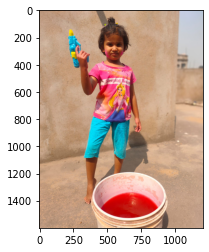

In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import argparse

def extract_features(filename, model):
        try:
            image = Image.open(filename)

        except:
            print("ERROR: Couldn't open image! Make sure the image path and extension is correct")
        image = image.resize((299,299))
        image = np.array(image)
        # for images that has 4 channels, we convert them into 3 channels
        if image.shape[2] == 4: 
            image = image[..., :3]
        image = np.expand_dims(image, axis=0)
        image = image/127.5
        image = image - 1.0
        feature = model.predict(image)
        return feature

def word_for_id(integer, tokenizer):
  for word, index in tokenizer.word_index.items():
      if index == integer:
          return word
  return None


def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'start'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        pred = model.predict([photo,sequence], verbose=0)
        pred = np.argmax(pred)
        word = word_for_id(pred, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'end':
            break
    return in_text


test_img_path = '/content/drive/MyDrive/Colab Notebooks/Flicker8k_Dataset/test_image1.jpg'
max_length = 29
tokenizer = load(open("/content/drive/MyDrive/Colab Notebooks/tokenizer.p","rb"))
model = load_model('models/model_9.h5')
xception_model = VGG16(include_top=False, pooling="avg")

photo = extract_features(test_img_path, xception_model)
img = Image.open(test_img_path)

description = generate_desc(model, tokenizer, photo, max_length)
print("\n\n")
print(description)
plt.imshow(img)




start brown dog be run through the grass end


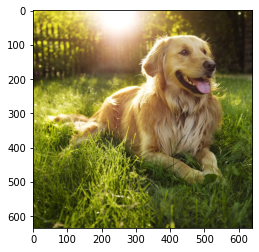

In [ ]:
test_img_path = '/content/drive/MyDrive/Colab Notebooks/Flicker8k_Dataset/test_image3.jpg'
max_length = 29
tokenizer = load(open("/content/drive/MyDrive/Colab Notebooks/tokenizer.p","rb"))
model = load_model('models/model_9.h5')
xception_model = VGG16(include_top=False, pooling="avg")

photo = extract_features(test_img_path, xception_model)
img = Image.open(test_img_path)

description = generate_desc(model, tokenizer, photo, max_length)
print("\n\n")
print(description)
plt.imshow(img)




start man in red short be stand on beach end


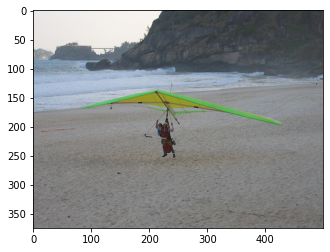

In [ ]:
test_img_path = '/content/drive/MyDrive/Colab Notebooks/Flicker8k_Dataset/207584893_63e73c5c28.jpg'
max_length = 29
tokenizer = load(open("/content/drive/MyDrive/Colab Notebooks/tokenizer.p","rb"))
model = load_model('models/model_9.h5')
xception_model = VGG16(include_top=False, pooling="avg")

photo = extract_features(test_img_path, xception_model)
img = Image.open(test_img_path)

description = generate_desc(model, tokenizer, photo, max_length)
print("\n\n")
print(description)
plt.imshow(img)

Q2: Let us define a sequence parity function as a function that takes in a sequence of binary inputs and returns a sequence indicating the number of 0’s in the input so far; specifically, if at time t the 0’s in the input so far is odd it returns 1, and 0 if it is even. For example, given input sequence [0, 1, 0, 1, 1, 0], the parity sequence is [1, 1, 0, 0, 0, 1]. 

In [ ]:
N, T, D, H = 2, 3, 4, 5

x = np.linspace(-0.1, 0.3, num=N*T*D).reshape(N, T, D)
h0 = np.linspace(-0.3, 0.1, num=N*H).reshape(N, H)
Wx = np.linspace(-0.2, 0.4, num=D*H).reshape(D, H)
Wh = np.linspace(-0.4, 0.1, num=H*H).reshape(H, H)
b = np.linspace(-0.7, 0.1, num=H)

h, _ = rnn_forward(x, h0, Wx, Wh, b)
expected_h = np.asarray([
  [
    [-0.42070749, -0.27279261, -0.11074945,  0.05740409,  0.22236251],
    [-0.39525808, -0.22554661, -0.0409454,   0.14649412,  0.32397316],
    [-0.42305111, -0.24223728, -0.04287027,  0.15997045,  0.35014525],
  ],
  [
    [-0.55857474, -0.39065825, -0.19198182,  0.02378408,  0.23735671],
    [-0.27150199, -0.07088804,  0.13562939,  0.33099728,  0.50158768],
    [-0.51014825, -0.30524429, -0.06755202,  0.17806392,  0.40333043]]])
print('h error: ', rel_error(expected_h, h))



In [ ]:
np.random.seed(231)

N, D, T, H = 2, 3, 10, 5

x = np.random.randn(N, T, D)
h0 = np.random.randn(N, H)
Wx = np.random.randn(D, H)
Wh = np.random.randn(H, H)
b = np.random.randn(H)

out, cache = rnn_forward(x, h0, Wx, Wh, b)

dout = np.random.randn(*out.shape)

dx, dh0, dWx, dWh, db = rnn_backward(dout, cache)

fx = lambda x: rnn_forward(x, h0, Wx, Wh, b)[0]
fh0 = lambda h0: rnn_forward(x, h0, Wx, Wh, b)[0]
fWx = lambda Wx: rnn_forward(x, h0, Wx, Wh, b)[0]
fWh = lambda Wh: rnn_forward(x, h0, Wx, Wh, b)[0]
fb = lambda b: rnn_forward(x, h0, Wx, Wh, b)[0]

dx_num = eval_numerical_gradient_array(fx, x, dout)
dh0_num = eval_numerical_gradient_array(fh0, h0, dout)
dWx_num = eval_numerical_gradient_array(fWx, Wx, dout)
dWh_num = eval_numerical_gradient_array(fWh, Wh, dout)
db_num = eval_numerical_gradient_array(fb, b, dout)

print('dx error: ', rel_error(dx_num, dx))
print('dh0 error: ', rel_error(dh0_num, dh0))
print('dWx error: ', rel_error(dWx_num, dWx))
print('dWh error: ', rel_error(dWh_num, dWh))
print('db error: ', rel_error(db_num, db))